In [1]:
# import modules
import datetime #, timedelta
import time
import json
import pandas as pd
import numpy as np
import decimal
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scienceplots
import matplotlib 

# from plotly.subplots import make_subplots
import plotly.graph_objects as go

import boto3
from boto3.dynamodb.conditions import Key, Attr

# Obtain secret key for AWS
f = open("secret.txt")
text = f.readlines()

# Access dynamodb on AWS
dynamodb = boto3.resource(
    "dynamodb",
    aws_access_key_id=text[0][:-1],
    aws_secret_access_key=text[1][:-1],
    region_name="us-east-2",
)

    
plt.style.use(['science','ieee','high-vis'])
# plt.rcParams['axes.linewidth'] = 1
# plt.rcParams['figure.dpi'] =300

w = 3.3 
h = 2.5

plt.rcParams['figure.constrained_layout.use'] = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]

In [2]:
# Scan through all Sessions2 data to get session items
table = dynamodb.Table('Sessions2')
params = {'ProjectionExpression': "dcosId,userId,user_email,vehicle_model,vehicle_maxChgRate_W,siteId,stationId,connectTime,startChargeTime,Deadline,energyReq_Wh,estCost,reg_centsPerHr,sch_centsPerHr,sch_centsPerKwh,sch_centsPerOverstayHr,#Dur,DurationHrs,choice,regular,scheduled,cumEnergy_Wh,peakPower_W,power,lastUpdate",
          'ExpressionAttributeNames': {"#Dur":"Duration"}}

# Repeat scan until LastEvaluatedKey is None
start = time.time()
done = False
start_key = None
temp = []
while not done:
    if start_key:
        params['ExclusiveStartKey'] = start_key
    response = table.scan(**params)
    temp.extend(response.get('Items', []))
    print("Length of Scanned Items is {0} items".format(len(temp)))
    start_key = response.get('LastEvaluatedKey', None)
    done = start_key is None

# Print elapsed time
end = time.time()
elapsed_time_min = np.floor((end-start)/60)
elapsed_time_sec = (end-start) % 60
elapsed_time = "Elapsed time: %d minutes, %d seconds" % (elapsed_time_min, elapsed_time_sec)
print(elapsed_time)

# Create dataframe
session_df = pd.DataFrame(temp)
del temp


Length of Scanned Items is 673 items
Length of Scanned Items is 1366 items
Length of Scanned Items is 2045 items
Length of Scanned Items is 2735 items
Length of Scanned Items is 3216 items
Elapsed time: 0 minutes, 13 seconds


## Expected Energy Demand, Duration

In [5]:
session_df['connectTime']  = pd.to_datetime(session_df['connectTime'] )
session_df['startChargeTime']  = pd.to_datetime(session_df['startChargeTime'] )
session_df['Deadline']  = pd.to_datetime(session_df['Deadline'] )
session_df['lastUpdate']  = pd.to_datetime(session_df['lastUpdate'])
session_df = session_df.sort_values(by='connectTime')
session_df = session_df[session_df['siteId'] == 25]
session_df['interArrivalTime_min'] = session_df['connectTime'].diff().dt.seconds / 60
plot_df = session_df[session_df['connectTime'].dt.year >= 2022]
session_df['arrHour']=session_df['connectTime'].dt.hour

session_df['cumEnergy_Wh']=session_df['cumEnergy_Wh'].astype(float)
session_df['cumEnergy_KWh']=session_df['cumEnergy_Wh']/1000
session_df['DurationHrs'] = session_df['DurationHrs'].astype(float)

In [6]:
# 1. peakPower_W = 0 and cumEnergy_W = 0: delete  
session_df = session_df[(session_df["peakPower_W"]!=0) & (session_df["cumEnergy_Wh"]!=0)]

# 2. Fix the user peak_powers 
# some users have historical peak power > 6.6 / 7 
user_df = session_df[['userId','peakPower_W','vehicle_maxChgRate_W']].groupby('userId').max()
user_df['session_counts'] = session_df[['userId','peakPower_W']].groupby('userId').count()

validate_users = user_df[(user_df['session_counts']==1) & (user_df['peakPower_W']<=6000) ].index.to_list()
user_df.reset_index(drop=False,inplace=True)

user_df.rename(columns={"peakPower_W":'historical_peakPower_w'},inplace=True)
session_df = session_df.merge(user_df[['userId','historical_peakPower_w']])

In [7]:

optimizer_time = pd.Timestamp(2023, 2, 7, 8)
session_df['endTime'] = session_df['startChargeTime'] + pd.to_timedelta(session_df['Duration'])
cols = ['connectTime','choice','power','endTime','Duration', 'userId', 'Deadline', 'startChargeTime','DurationHrs','dcosId', 'lastUpdate' ]
session_df[(session_df['startChargeTime']>optimizer_time)].sort_values(by='connectTime')[cols]

,connectTime,choice,power,endTime,Duration,userId,Deadline,startChargeTime,DurationHrs,dcosId,lastUpdate
942,2023-02-07 08:32:19,REGULAR,"[{'power_W': 6736, 'timestamp': 1675812017}]",2023-02-07 15:20:17,0 days 06:47:48,792,NaT,2023-02-07 08:32:29,6.79666,4150,2023-02-07 15:20:17
2333,2023-02-07 08:39:32,REGULAR,"[{'power_W': 6682, 'timestamp': 1675806309}]",2023-02-07 13:45:09,0 days 05:03:48,1233,NaT,2023-02-07 08:41:21,5.06333,4151,2023-02-07 13:45:09
1792,2023-02-07 09:02:28,SCHEDULED,"[{'power_W': 4497, 'timestamp': 1675810509}]",2023-02-07 14:55:09,0 days 05:51:44,1126,2023-02-07 15:00:00,2023-02-07 09:03:25,5.86222,4153,2023-02-07 14:55:09
1392,2023-02-07 09:19:18,REGULAR,"[{'power_W': 3576, 'timestamp': 1675806309}]",2023-02-07 13:45:09,0 days 04:24:03,988,NaT,2023-02-07 09:21:06,4.40083,4154,2023-02-07 13:45:09
1995,2023-02-07 09:50:38,REGULAR,"[{'power_W': 6624, 'timestamp': 1675809308}]",2023-02-07 14:35:08,0 days 04:44:16,1149,NaT,2023-02-07 09:50:52,4.73777,4155,2023-02-07 14:35:08
...,...,...,...,...,...,...,...,...,...,...,...
1760,2023-03-02 08:33:27,REGULAR,"[{'power_W': 1062, 'timestamp': 1677774908}, {...",2023-03-02 19:00:09,0 days 10:26:36,1021,NaT,2023-03-02 08:33:33,10.44333,4383,2023-03-02 19:00:09
2228,2023-03-02 12:11:52,REGULAR,"[{'power_W': 3385, 'timestamp': 1677788708}, {...",2023-03-02 18:10:09,0 days 05:49:14,1190,NaT,2023-03-02 12:20:55,5.82055,4384,2023-03-02 18:10:09
501,2023-03-02 13:48:56,REGULAR,"[{'power_W': 2432, 'timestamp': 1677793808}, {...",2023-03-02 17:05:08,0 days 03:15:49,627,NaT,2023-03-02 13:49:19,3.26361,4385,2023-03-02 17:05:08
1598,2023-03-02 14:56:44,REGULAR,"[{'power_W': 3904, 'timestamp': 1677798008}, {...",2023-03-02 17:10:15,0 days 02:12:48,1067,NaT,2023-03-02 14:57:27,2.21333,4386,2023-03-02 17:10:15


In [8]:
high_power_idx = list(session_df[session_df['historical_peakPower_w'] >= 5000].index)
low_power_idx = list(session_df[session_df['historical_peakPower_w'] < 5000].index)

session_df['highPower'] = pd.Series(dtype=int)

session_df.loc[high_power_idx ,'highPower'] = 1
session_df.loc[low_power_idx ,'highPower'] = 0

session_df.loc[high_power_idx ,'userPower_kW'] = 6.6
session_df.loc[low_power_idx ,'userPower_kW'] = 3.3

In [9]:
plt.rcParams['figure.dpi'] =300

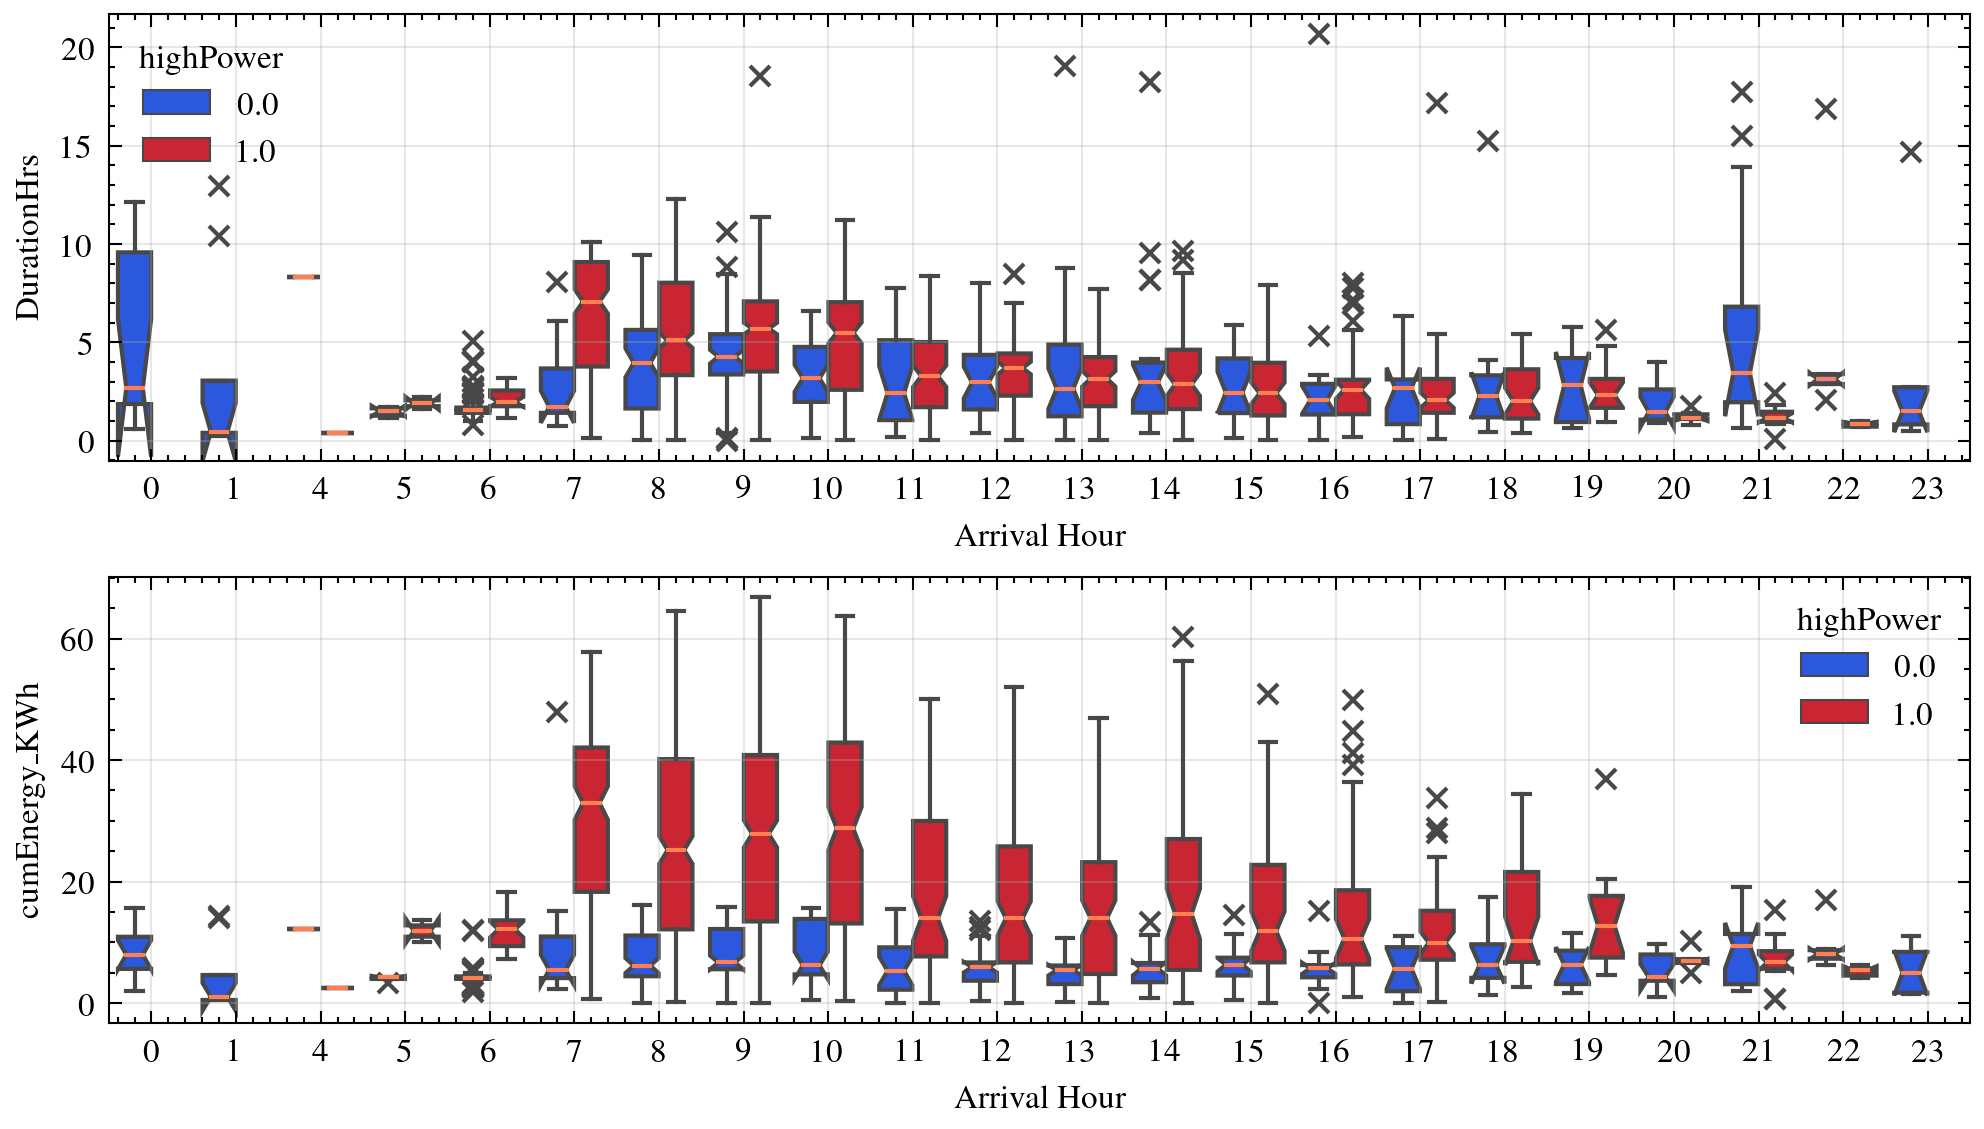

In [10]:
fig,ax= plt.subplots(2,1,figsize=( w*2, h*1.5 ))

sns.boxplot(
    data=session_df, x="arrHour", y="DurationHrs",hue='highPower',
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},ax=ax[0]
)

sns.boxplot(
    data=session_df, x="arrHour", y="cumEnergy_KWh",hue='highPower',
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},ax=ax[1]
)

for i in [0,1]:
    ax[i].grid(alpha=0.3)
    ax[i].set_xlabel("Arrival Hour")

In [11]:
iterables = [[0,1], range(0,24)]
idx = pd.MultiIndex.from_product(iterables, names=['highPower','arrHour'])
# pd.DataFrame(index=idx,columns = ['DurationHrs', 'cumEnergy_Wh', 'interArrivalTime_min', 'arrivalHour','cumEnergy_KWh', 'count'])
expected_demand = session_df.groupby(['highPower','arrHour']).mean()
expected_demand['count'] = session_df.groupby(['highPower','arrHour']).count()['dcosId']
expected_demand = expected_demand.reindex(idx).reset_index(drop=False)
expected_demand.rename(columns = {'cumEnergy_Wh':"estEnergyWh", 
                                  'cumEnergy_KWh':"estEnergykWh", 
                                  "DurationHrs":"estDurationHrs"},inplace=True)


expected_demand['count'].fillna(0,inplace=True)
# expected_demand.fillna(method='ffill',inplace=True)

/var/folders/6_/6qv23sh14kd4c6d7hs6wlvg00000gn/T/ipykernel_62534/4178246239.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  expected_demand = session_df.groupby(['highPower','arrHour']).mean()


In [12]:
for i in range(0, len(expected_demand), 24):
    group = expected_demand.iloc[i:i+24]
    # if group.iloc[0].isna().any():
    #     group.iloc[0].fillna(method='bfill', inplace=True)
    group.fillna(method='ffill', inplace=True)
    group.fillna(method='bfill', inplace=True)

/var/folders/6_/6qv23sh14kd4c6d7hs6wlvg00000gn/T/ipykernel_62534/2789656942.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.fillna(method='ffill', inplace=True)
/var/folders/6_/6qv23sh14kd4c6d7hs6wlvg00000gn/T/ipykernel_62534/2789656942.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.fillna(method='bfill', inplace=True)


In [13]:
expected_demand

,highPower,arrHour,estDurationHrs,estEnergyWh,interArrivalTime_min,estEnergykWh,userPower_kW,count
0,0,0,5.115760,8349.500000,587.538889,8.349500,3.3,12.0
1,0,1,3.232010,4157.500000,395.362500,4.157500,3.3,8.0
2,0,2,3.232010,4157.500000,395.362500,4.157500,3.3,0.0
3,0,3,3.232010,4157.500000,395.362500,4.157500,3.3,0.0
4,0,4,8.323880,12213.000000,704.250000,12.213000,3.3,1.0
5,0,5,1.465440,3995.000000,1016.436667,3.995000,3.3,5.0
6,0,6,1.637458,4215.265306,988.112857,4.215265,3.3,245.0
7,0,7,2.778343,9230.684211,874.194737,9.230684,3.3,19.0
8,0,8,4.005247,7516.594595,408.026577,7.516595,3.3,74.0
9,0,9,4.323759,8331.211765,230.774510,8.331212,3.3,85.0


# Test Station Level Optimizer
Currently optimizer works only with the simulator. <br>
Start with the simple case: Run with no-on going sessions. 



In [14]:
import optimizer_station as opt
# We define the timesteps in the APP as 15 minute 
delta_t = 0.25 #hour 
print("For delta_t: ",delta_t, "max number of intervals:",24/delta_t)
################## Define the TOU Cost ##########################################
## the TOU cost is defined considering the delta_t above, if not code raises an error.##

# off-peak 0.175  cents / kwh 
TOU_tariff = np.ones((96,)) * 17.5
## 4 pm - 9 pm peak 0.367 cents / kwh 
TOU_tariff[64:84] = 36.7
## 9 am - 2 pm super off-peak 0.49 $ / kWh  to cents / kwh

TOU_tariff[36:56] = 14.9

For delta_t:  0.25 max number of intervals: 96.0


In [13]:
 opt.Parameters?

In [15]:
%%time
## Task 1: Run for 24 hours with no on going sessions 

expected_demand['sch_centsPerHr'] = pd.Series()
expected_demand['reg_centsPerHr'] = pd.Series()
expected_demand['sch_expected_power_W'] = pd.Series()
expected_demand['reg_expected_power_W'] = pd.Series()

#### TODO: YIFEI RUN OPTIMIZER FOR THE EACH ROW IN THIS DATAFRAME WITH 0 DEMAND CHARGE PENALTY ####
# ASSUME NO VEHICLES
# DON'T USE SINGLE CHARGER, ONLY USE STATION LEVEL OPTIMIZER
# When recording the powers use the same format in the sessions.csv

par = opt.Parameters(z0 = np.array([25, 30, 1, 1]).reshape(4, 1),
                         Ts = delta_t,
                         eff = 1.0,
                         soft_v_eta = 1e-4,
                         opt_eps = 0.0001,
                         TOU = TOU_tariff,
                     demand_charge_cost=12)

for row in range(len(expected_demand)):

    if expected_demand.loc[row, 'estDurationHrs'] > 0:
        try:
            arrival_hour = expected_demand.loc[row, 'arrHour']
            duration_hour = expected_demand.loc[row, 'estDurationHrs']
            e_need = expected_demand.loc[row, 'estEnergykWh']

            ### Yifei: Also do we define the event here or in the optimizer?
            event = {
                "time": int(arrival_hour / delta_t),
                "e_need": e_need,
                "duration": int(duration_hour / delta_t),
                "station_pow_max": 6.6,
                "user_power_rate": expected_demand.loc[row, 'userPower_kW'],
                "limit_reg_with_sch": False,
                "limit_sch_with_constant": False,
                "sch_limit": 0,
                "historical_peak" : 12,
            }

            prb = opt.Problem(par=par, event=event)

            # Yifei: The station object, here we assume no ongoing sessions. The form of this object is not decided yet. Dict or Class?
            station_info = None

            obj = opt.Optimization_station(par, prb, station_info, arrival_hour)
            station, res = obj.run_opt()

            reg_centsPerHr, sch_centsPerHr = res["reg_centsPerHr"], res['sch_centsPerHr']

            expected_demand.loc[row, 'sch_centsPerHr'] = sch_centsPerHr 
            expected_demand.loc[row, 'reg_centsPerHr'] = reg_centsPerHr 
            expected_demand.loc[row, 'sch_expected_power_W' ] = json.dumps(list(res["sch_powers"].flatten()))
            expected_demand.loc[row, 'reg_expected_power_W' ] = json.dumps(list(res["reg_powers"].flatten()))
        except AssertionError:
            print("Error:",row)
    else:
        expected_demand.loc[row, 'sch_centsPerHr'] = 0
        expected_demand.loc[row, 'reg_centsPerHr'] = 0

After 14 iterations, we got -0.233271  improvement, and claim convergence.
The prices(SCH & REG) are 28.270486 30.631095
After 14 iterations, we got -0.109127  improvement, and claim convergence.
The prices(SCH & REG) are 28.270537 30.630946
After 14 iterations, we got -0.109127  improvement, and claim convergence.
The prices(SCH & REG) are 28.270537 30.630946
After 14 iterations, we got -0.109127  improvement, and claim convergence.
The prices(SCH & REG) are 28.270537 30.630946
After 4 iterations, we got -0.363537  improvement, and claim convergence.
The prices(SCH & REG) are 25.390972 29.860721
After 14 iterations, we got -0.104333  improvement, and claim convergence.
The prices(SCH & REG) are 28.270569 30.631192
After 14 iterations, we got -0.108938  improvement, and claim convergence.
The prices(SCH & REG) are 28.139647 30.468508
After 9 iterations, we got -0.049646  improvement, and claim convergence.
The prices(SCH & REG) are 27.344094 30.597893
After 4 iterations, we got -0.0139

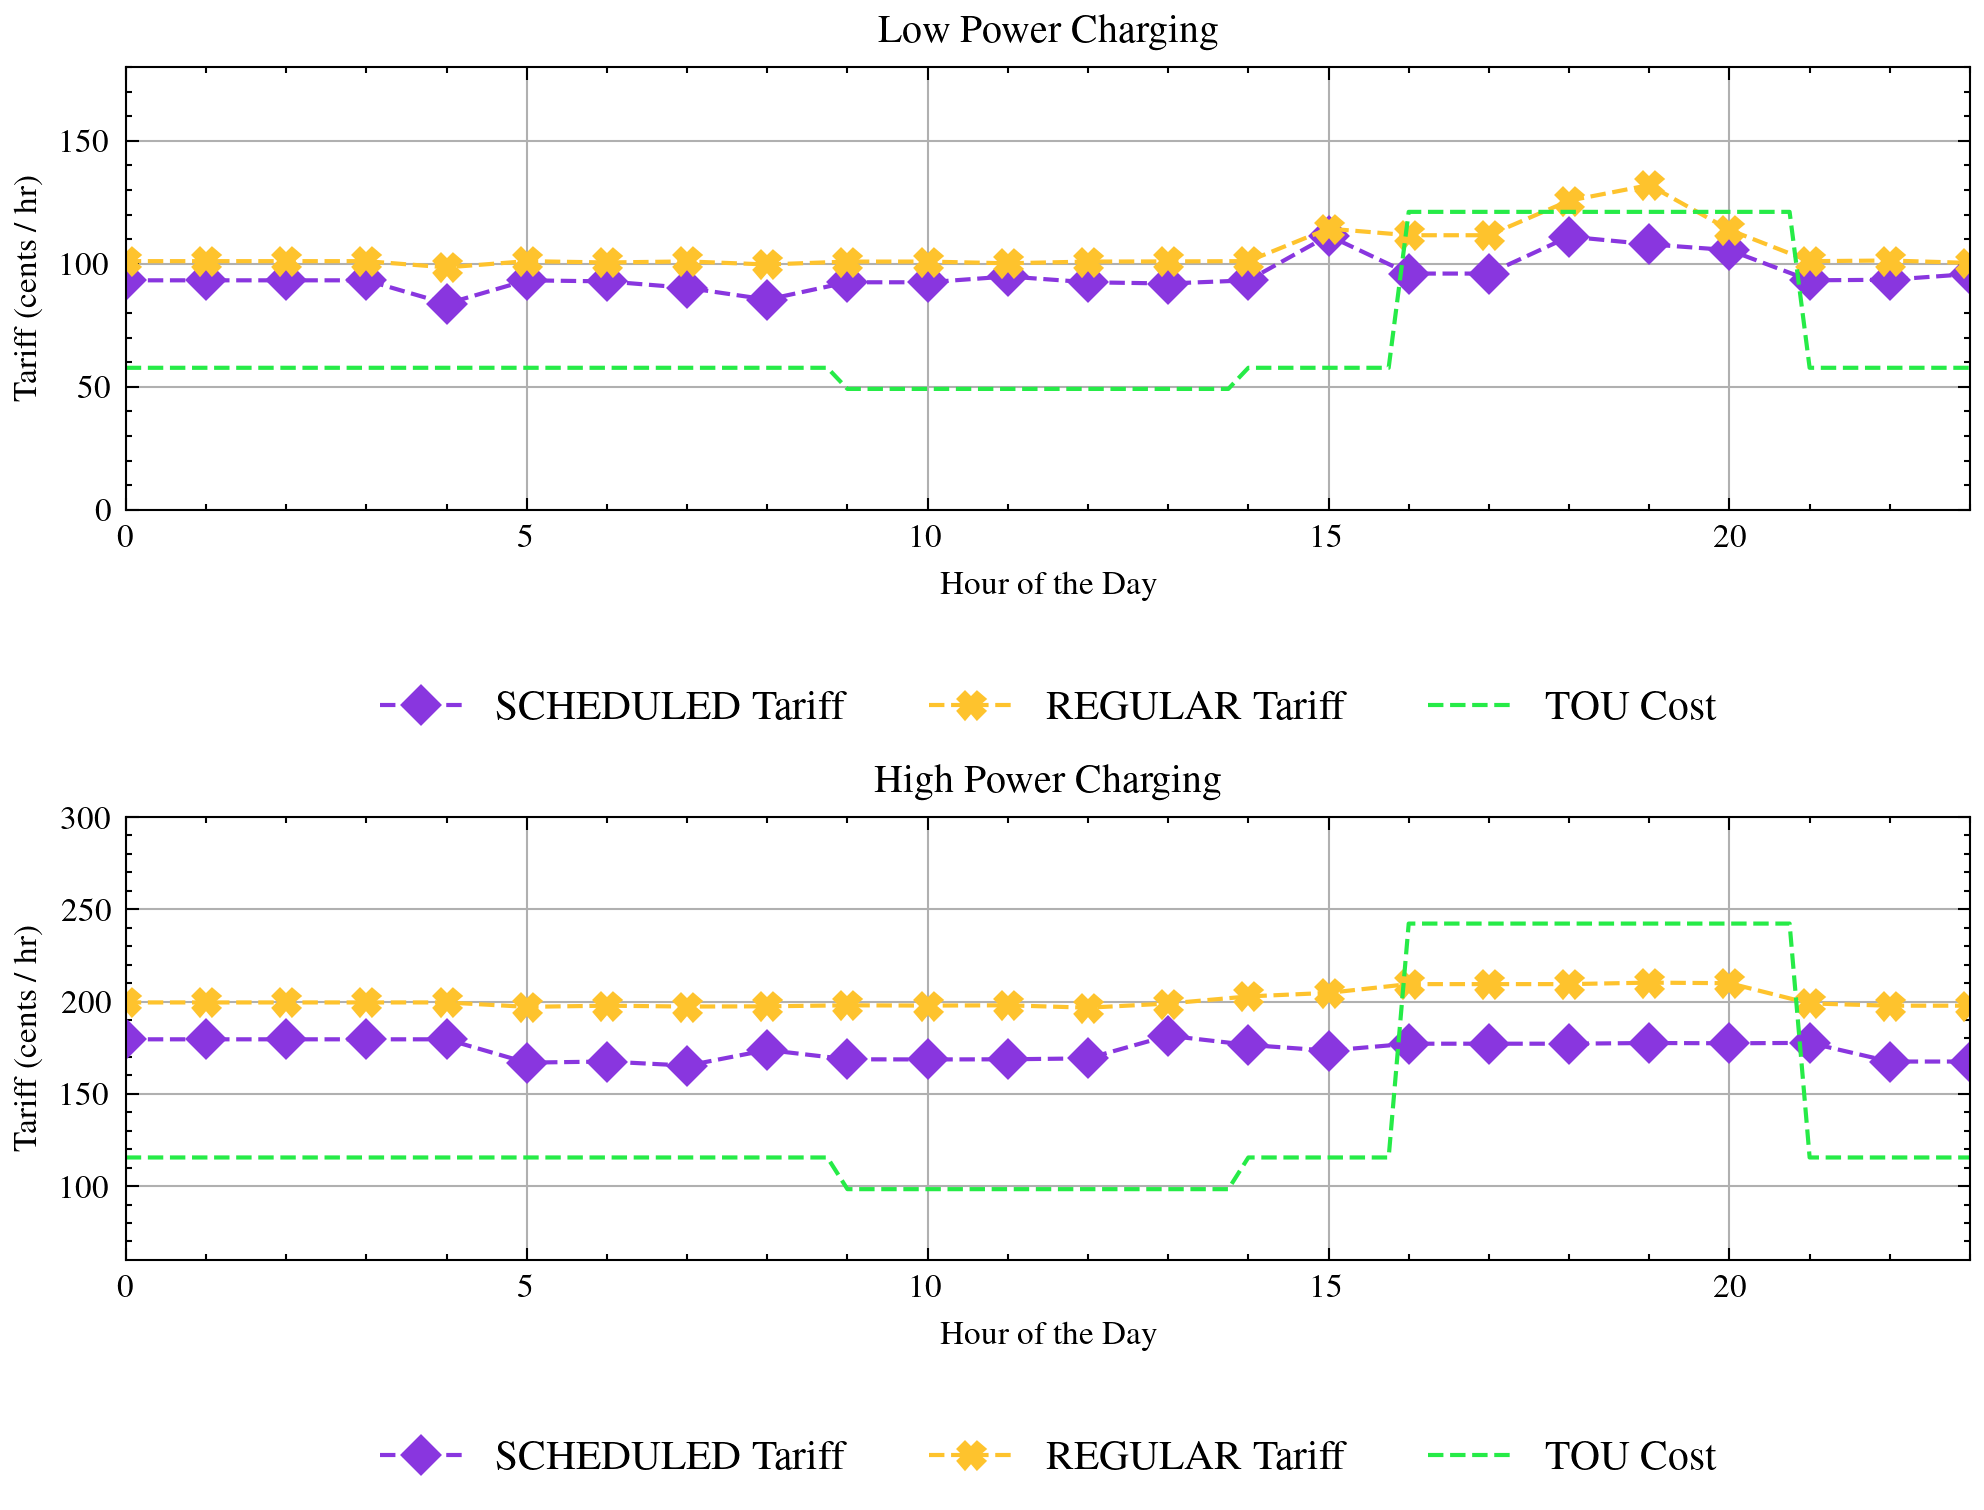

In [16]:
high_TOU = TOU_tariff * 6.6
low_TOU = TOU_tariff * 3.3

# Plot initial guess vs optimization result 
fig,axes= plt.subplots(2,1,figsize=(w * 2 ,h*2))
# Objective Value for each iteration 
ax=axes[0]
arrHour = expected_demand[expected_demand['highPower']==0]['arrHour'].values

expected_demand['reg_centsPerHr'].values
expected_demand['sch_centsPerHr'].values

ax.plot(arrHour, expected_demand[expected_demand['highPower']==0]['sch_centsPerHr'].values, 
        label = 'SCHEDULED Tariff', 
        marker = 'D',
        linestyle = "--",color=high_vis_map[3])
ax.plot(arrHour, expected_demand[expected_demand['highPower']==0]['reg_centsPerHr'].values, color=high_vis_map[4], label = 'REGULAR Tariff',marker ='X',linestyle = "--")
ax.plot(np.arange(0,24,0.25), low_TOU, label = 'TOU Cost', ms=0,marker ='X',
        linestyle = "--",
       color=high_vis_map[2])

ax.set_ylim(0,180)
ax.set_xlim(0,23)
ax.grid()
ax.set_title("Low Power Charging")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Tariff (cents / hr)")
# ax.set_title("Objective Value")
ax.legend(loc = 0)
ax.legend(bbox_to_anchor=(0.5, -0.45), loc='center', ncol=3,fontsize=10)


ax=axes[1]
arrHour = expected_demand[expected_demand['highPower']==1]['arrHour'].values

expected_demand['reg_centsPerHr'].values
expected_demand['sch_centsPerHr'].values

ax.plot(arrHour, expected_demand[expected_demand['highPower']==1]['sch_centsPerHr'].values, 
        label = 'SCHEDULED Tariff', 
        marker = 'D',
        linestyle = "--",color=high_vis_map[3])
ax.plot(arrHour, expected_demand[expected_demand['highPower']==1]['reg_centsPerHr'].values, color=high_vis_map[4], label = 'REGULAR Tariff',marker ='X',linestyle = "--")
ax.plot(np.arange(0,24,0.25), high_TOU, label = 'TOU Cost', ms=0,marker ='X',
        linestyle = "--",
       color=high_vis_map[2])

ax.set_ylim(60,300)
ax.set_xlim(0,23)
ax.grid()
ax.set_title("High Power Charging")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Tariff (cents / hr)")
# ax.set_title("Objective Value")
ax.legend(loc = 0)
ax.legend(bbox_to_anchor=(0.5, -0.45), loc='center', ncol=3,fontsize=10)

# fig.savefig('Figures/fig2a.pdf', dpi=300)

# Plot Powers

In [17]:
import json
import math
from analysis import plot_max_min_power, plot_arrival_departure

In [18]:
expected_demand[(expected_demand['highPower']==1)].set_index('arrHour')

,highPower,estDurationHrs,estEnergyWh,interArrivalTime_min,estEnergykWh,userPower_kW,count,sch_centsPerHr,reg_centsPerHr,sch_expected_power_W,reg_expected_power_W
arrHour,,,,,,,,,,,
0,1,0.387770,2471.000000,501.550000,2.471000,6.6,0.0,179.517227,199.494299,"[6.6, 3.284000000000001]","[6.6, 3.284000000000001]"
1,1,0.387770,2471.000000,501.550000,2.471000,6.6,0.0,179.517227,199.494299,"[6.6, 3.284000000000001]","[6.6, 3.284000000000001]"
2,1,0.387770,2471.000000,501.550000,2.471000,6.6,0.0,179.517227,199.494299,"[6.6, 3.284000000000001]","[6.6, 3.284000000000001]"
3,1,0.387770,2471.000000,501.550000,2.471000,6.6,0.0,179.517227,199.494299,"[6.6, 3.284000000000001]","[6.6, 3.284000000000001]"
4,1,0.387770,2471.000000,501.550000,2.471000,6.6,1.0,179.517227,199.494299,"[6.6, 3.284000000000001]","[6.6, 3.284000000000001]"
5,1,1.907635,11853.500000,1084.550000,11.853500,6.6,2.0,166.888493,197.107703,"[6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 1.21400000...","[6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 1.21400000..."
6,1,2.091373,11943.230769,619.387821,11.943231,6.6,26.0,167.475933,197.735276,"[6.282980467182145, 6.282980467182145, 6.27764...","[6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 1.57292307..."
7,1,6.417033,31044.288043,491.070652,31.044288,6.6,184.0,165.263604,197.271248,"[1.7181133979044818, 1.7181133979044685, 1.718...","[6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, ..."
8,1,5.442885,26874.639474,275.369956,26.874639,6.6,380.0,173.737744,197.391683,"[1.0867484121867447e-11, 1.0867484121871813e-1...","[6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, 6.6, ..."


Text(0.5, 0.98, 'Hour 11')

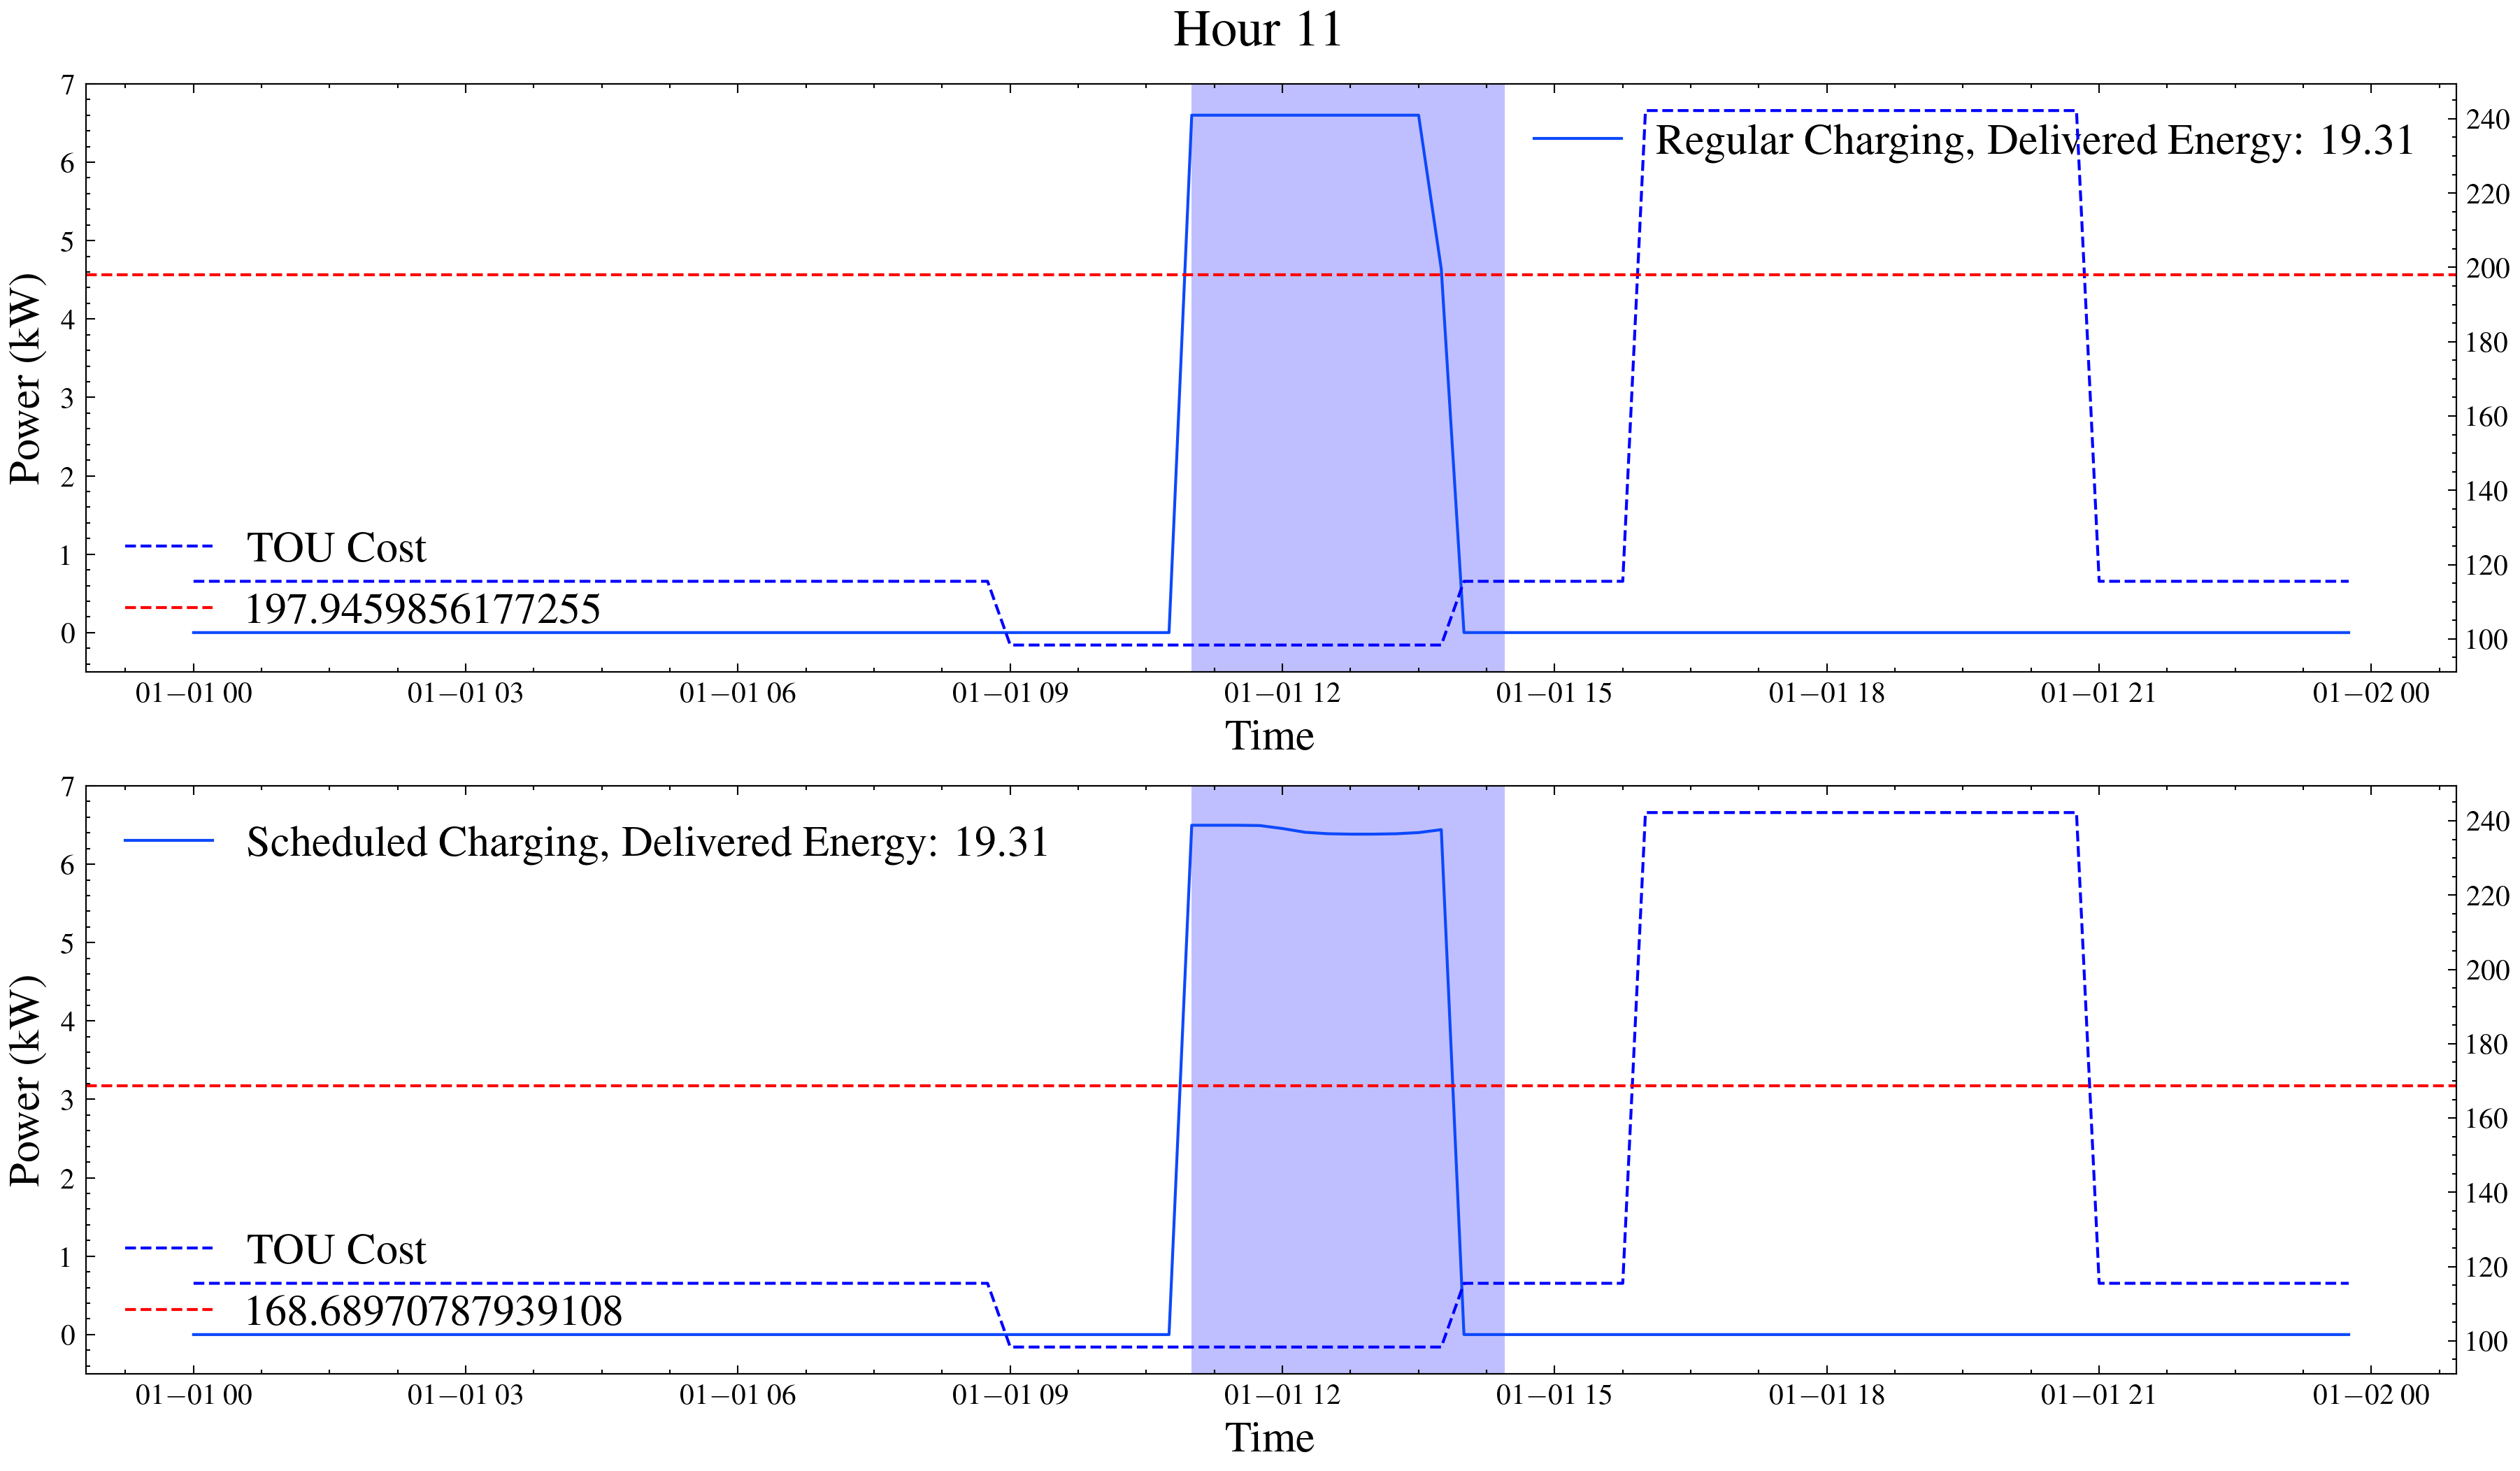

In [19]:
#### RECORD AND CHECK ALL HOURS MAYBE PUT THEM IN A GOOGLE SLIDES. COMMENT ON THE RESULTS. LABEL THE PROBLEM CASES IF ANY. 
steps_in_hr = 4
eff = 1 
interval_size_minutes = int(60 * delta_t)
assert steps_in_hr == int(1/delta_t)

arrHour = 11
station_pow_max = 6.6
interval_size_hour = 0.25

high_powers = expected_demand[(expected_demand['highPower']==1)].set_index('arrHour')

power = np.array(json.loads(high_powers.loc[arrHour,'sch_expected_power_W']))
e_need = high_powers.loc[arrHour ,"estEnergykWh"]
duration = high_powers.loc[arrHour ,"estDurationHrs"]

arrival_interval = int(arrHour *steps_in_hr)
duration_interval =  int(duration * 60 / interval_size_minutes)


###### HAVE THE SAME DISCRETIZATION HERE IN THE OPTIMIZER ############################
N_asap = math.ceil((e_need / station_pow_max / eff * int(1 / interval_size_hour)))
N_asap_remainder = (e_need / station_pow_max / eff * int(1 / interval_size_hour)) % 1


try:
    sch_arr = np.zeros((96,1))
    reg_arr = np.zeros((96,1))  
    timerange = pd.date_range("1/1/2021", periods=96, freq="{}min".format(interval_size_minutes ))
    sch_arr[arrival_interval:(arrival_interval+duration_interval)] = power.reshape((duration_interval,1))
    reg_arr[arrival_interval:(arrival_interval+N_asap)] = station_pow_max 
    reg_arr[(arrival_interval+N_asap) - 1] = station_pow_max * N_asap_remainder

except: 
    timerange = pd.date_range("1/1/2021", periods=96 * 2, freq="{}min".format(interval_size_minutes))
    sch_arr = np.zeros((96*2,1))
    reg_arr = np.zeros((96*2,1))
    sch_arr[arrival_interval:(arrival_interval+duration_interval)] = power.reshape((duration_interval,1))
    reg_arr[arrival_interval:(arrival_interval+N_asap)] = station_pow_max
    reg_arr[(arrival_interval+N_asap) - 1] = station_pow_max * N_asap_remainder
    high_TOU = np.concatenate([high_TOU,high_TOU])


fig,(ax1, ax2) = plt.subplots(2,1,figsize=(12,7) ,)

ax1.plot(timerange, reg_arr, label = "Regular Charging, Delivered Energy: "+str(np.round(np.sum(reg_arr * 0.25),2)))
ax = ax1.twinx()
ax.plot(timerange , high_TOU, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")

reg_price_cents_hour = high_powers.loc[arrHour,'reg_centsPerHr']
ax.axhline(reg_price_cents_hour  ,linestyle='--',color='red', 
           label = reg_price_cents_hour)
ax.legend(loc=3)
ax2.plot(timerange, sch_arr, label = "Scheduled Charging, Delivered Energy: "+str(np.round(np.sum(sch_arr * 0.25),2)))
ax = ax2.twinx()

sch_price_cents_hour = high_powers.loc[arrHour,'sch_centsPerHr']


ax.plot(timerange , high_TOU, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")
ax.axhline(sch_price_cents_hour  ,linestyle='--',color='red', 
           label =sch_price_cents_hour)
ax.legend(loc=3)
plot_arrival_departure([ax1,ax2], arrHour, 0, int(arrHour + duration), 
                       int(60 * ((arrHour + duration) % int(arrHour + duration))))

# plot_max_min_power([ax1,ax2],6.6)
for ax in [ax1,ax2]:
    ax.set_ylim(-0.5,7)
    ax.legend(loc=0)
    ax.legend(loc=0)
    ax.set_xlabel("Time")
    ax.set_ylabel("Power (kW)")


fig.suptitle("Hour {}".format(arrHour))

# Optimization with station information

In [20]:
optimizer_time = pd.Timestamp(2023, 2, 7, 8, 0, 0)
print(optimizer_time)
print(pd.to_datetime(optimizer_time).value)

2023-02-07 08:00:00
1675756800000000000


In [22]:
def unixTime(timeStamp):
    return int(pd.to_datetime(timeStamp).timestamp())

## Check this for the format of the final output powers. You can generate it as you wish. 

def dummyUserPower(choice):
    
    """ Returns Array but this can also be a dictionary """

    ### Yifei: In the optimizer, we require strictly that HIGH power corresponds to 6.6 kW and LOW power corresponds to 3.3 kW.
    ### Aka, for REG, we require the first several intervals to be 6.6 kW (must satisfy, cannot be other values like 6, 6, 6...)
    
    t0 = unixTime(pd.Timestamp(2023, 2, 7, 7, 30 , 0 ))
    t1 = unixTime(pd.Timestamp(2023, 2, 7, 7, 45 , 0 ))
    t2 = unixTime(pd.Timestamp(2023, 2, 7, 8, 0 , 0 )) ## Current TS
    t3 = unixTime(pd.Timestamp(2023, 2, 7, 8, 15 , 0 ))
    t4 = unixTime(pd.Timestamp(2023, 2, 7, 8, 30 , 0 ))
    t5 = unixTime(pd.Timestamp(2023, 2, 7, 8, 45 , 0 ))
    t6 = unixTime(pd.Timestamp(2023, 2, 7, 9, 0 , 0 ))
    t7 = unixTime(pd.Timestamp(2023, 2, 7, 9, 15 , 0 ))
    t8 = unixTime(pd.Timestamp(2023, 2, 7, 9, 30 , 0 ))
    t9 = unixTime(pd.Timestamp(2023, 2, 7, 9, 45 , 0 ))
    
    p0 = 6600
    p1 = 6600
    p2 = 6600
    p3 = 6600
    p4 = 6600
    p5 = 3300

    if choice == "REG":
        powers = np.array([ [t0, p0], [t1, p1], [t2, p2], [t3, p3], [t4, p4],[t5, 3300]])

    elif choice == "SCH":
        powers = np.array([ [t0, 0], [t1, p1], [t2, p2], [t3, p3], [t4, p4],[t5, 6600], 
                            [t6, 0], [t7, 0], [t8, 0], [t9, 0]])
    else:
        powers = np.zeros(shape=(6,2))
    return powers

def dummyStateRecord():
    """ 
    Returns: List of Dictionaries
    Each entry is a state dictionary with keys: 
    
    monthlyPeak, int
    timeStamp, int
    sessions, list of dictionaries with keys
    dcosId, int
    choice, string
    powerRate, string
    energyNeeded, float
    deadline, int
    optPower, array 
        """
    
    stateRecord = [
        {"monthlyPeak":18, 
         "timeStamp":unixTime(pd.Timestamp(2023, 2, 7, 7, 45 , 0 )), ## Last record TS(decision of the last vehicle)
         "sessions": [ 
             {
                "dcosId" : 1001,
                "choice": "SCH",
                "powerRate": "HIGH",
                "energyNeeded" : 8250,
                "deadline" : unixTime(pd.Timestamp(2023, 2, 7, 8, 45 , 0 )), # So here the values are all discretized to 15 min intervals?
                "optPower" : dummyUserPower("SCH") 
             }, 
             {
                "dcosId" : 1002,
                "choice": "REG",
                "powerRate": "HIGH",
                "energyNeeded" : 9075,
                "deadline" : unixTime(pd.Timestamp(2023, 2, 7, 8, 45 , 0 )),
                "optPower" : dummyUserPower("REG") 
             }, 
         ]
        }
    ]
    print(stateRecord[0]["sessions"][0]["optPower"][:,1].sum() * 0.25)
#     assert  == 3750
    
    return stateRecord

def arrHourList(arrHour, optHorizon):
    """ arrHour, int: current optimization hour
        optHorizon, int: how long to optimize in hours """ 
    if arrHour <= (24-optHorizon): 
        return list(range(arrHour,(arrHour+optHorizon)))
    else: 
        lst = list(range(arrHour,24))
        lst.extend(list(range( 0 , ((arrHour+optHorizon)-24) )))

        return lst

## Input format convertion(from raw input data to the format of the optimizer)

In [23]:
import datetime
import copy
def data_format_convertion(stateRecords, opt_hour, delta_t):
    timezone = datetime.timezone(datetime.timedelta(hours=0))
    stateRecord = copy.deepcopy(stateRecords[0]["sessions"])
    if not stateRecord:
        return None
    # num_users = len(stateRecord)
    res = []
    for user in stateRecord:
        user["optPower"] = user["optPower"].tolist()
        user["power_rate"] = 6.6 if user["powerRate"] == "HIGH" else 3.3

        start_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][0][0]), timezone) # the timestamp of the first time slot
        user["start_time"] = float(start_time_obj.hour + start_time_obj.minute / 60)

        end_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][-1][0]), timezone) # Or retrieve the last time slot??
        user["end_time"] = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
        if user["end_time"] <= opt_hour:
            continue

        user["optPower"] = np.array([x[1] for x in user["optPower"]]) / 1000
        user["price"] = 25 if user["choice"] == "SCH" else 30
        user["energyNeeded"] = float(user["energyNeeded"]) / 1000
        del(user["deadline"])
        res.append(user)

    return res

For stateRecords with multiple timestamps, do we sort it every time to make sure stateRecord[0] is the last timestamp?

Where should I check the status(are vehicles still in the station)? Inside or outside optimizer?

Also need the TOU(can be derived from start and deadline and global TOU) and prices for existing vehicles!

### Update the power profiles in the stateRecords according to the opt's output(post-processing)

If we only need to generate the price table, then we do not need to update the stateRecords(power profiles). However, once a new user comes and makes its decision, the power profile of existing users shall be updated.(Is it correct?)

In [24]:
def convertOutput(stateRecords, station_info, res, opt_time, user_choice):
    """ Convert the output to the original format """
    new_state = copy.deepcopy(stateRecords[0])
    new_state["monthlyPeak"] = round(res["sch_max"], 2) if user_choice == "SCH" else round(res["reg_max"], 2)
    new_state["timeStamp"] = unixTime(pd.Timestamp(2023, 2, 7, opt_time, 0 , 0))
    finishing_list = []
    if new_state["sessions"]:
        for i, user in enumerate(new_state["sessions"]):
            timezone = datetime.timezone(datetime.timedelta(hours=0))
            end_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][-1][0]), timezone) # Or retrieve the last time slot??
            end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
            if end_time <= opt_time:
                finishing_list.append(i)
                continue
            user_update = [d for d in station_info if d["dcosId"] == user["dcosId"]][0] # The updated user info from opt output
            TOU_idx = user_update["TOU_idx"]
            user["optPower"][TOU_idx:, 1] = (user_update["optPower"][TOU_idx:] * 1000).astype(int) # Retaining the UNIXTIME and updating the power
    if finishing_list:
        # Remove the index in finishing_list from new_state["sessions"]
        new_state["sessions"] = [user for i, user in enumerate(new_state["sessions"]) if i not in finishing_list]
    new_user = dict()
    new_user["dcosId"] = "dummyUser"
    new_user["choice"] = user_choice  # This choice and OPT power / price are decided outside the optimizer
    new_user["powerRate"] = "HIGH" if res["power_rate"] == 6.6 else "LOW"
    new_user["energyNeeded"] = int(1000 * res['e_need'])
    new_user["optPower"], new_user["deadline"] = powerOutput(res, user_choice)
    ## TO-DO: How to get the deadline? Is it the rounded and discretized time or the actual time? For example, 8:45(Rounded) / 8:47(Actual)?
    new_state["sessions"].append(new_user)

    return new_state

def powerOutput(res, user_choice):
    """ Convert the output to the original format """
    start_timestamp = res["time_start"] * delta_t
    start_timestamp_hour = int(start_timestamp)
    start_timestamp_minute = int((start_timestamp % 1) * 60)
    start_time = datetime.datetime(2023, 2, 7, start_timestamp_hour, start_timestamp_minute, 0)
    t0 = unixTime(start_time)

    end_timestamp = res["time_end_SCH"] * delta_t if user_choice == "SCH" else res["time_end_REG"] * delta_t
    end_timestamp_hour = int(end_timestamp)
    end_timestamp_minute = int((end_timestamp % 1) * 60)
    end_time = datetime.datetime(2023, 2, 7, end_timestamp_hour, end_timestamp_minute, 0)
    t1 = unixTime(end_time)

    timestamps = np.arange(t0, t1, delta_t * 60 * 60).astype(int)   # In seconds, for example, 0.25 * 60 = 15min in seconds
    optPower = copy.deepcopy(res["sch_powers"]) * 1000 if user_choice == "SCH" else copy.deepcopy(res["reg_powers"]) * 1000
    optPower = optPower.astype(int)
    output_power = np.concatenate((timestamps.reshape(-1, 1), optPower.reshape(-1, 1)), axis=1)

    return output_power, t1

## Generate the expected demand price table

In [25]:
## TO-DO Yifei Function Here
from collections import defaultdict
def generateOptPricePower(expectedDemand):

    optTime = pd.Timestamp(2023, 2, 7, 8, 0, 0)
    unixOptTime = unixTime(optTime)
    arrival_hour = optTime.hour

    # We only take the next 4 hours of the price table

    optHours = arrHourList(arrival_hour, optHorizon=4)
    ## read the stateRecords last entry
    stateRecords = dummyStateRecord()

    try:
        expected_demand.set_index(['arrHour','highPower'],inplace=True)
    except KeyError:
        print("")

    States = defaultdict(dict)

    ## read the expected demand table
    for highPower in [0,1]:
        for hour in optHours:

            ## Here we are converting the optimization time to the arrival time
            hr = optTime.hour
            minute =  optTime.minute / 60

            arrival_time = hr + minute
            duration_hour = expected_demand.loc[(hour, highPower), 'estDurationHrs']
            e_need = expected_demand.loc[(hour, highPower), 'estEnergykWh']

            ### How do duration_hour and e_need update after each re-optimization?

            event = {
                "time": int(hour / delta_t), # Hour or Arrival_hour?
                "e_need": e_need,
                "duration": int(duration_hour / delta_t),
                "station_pow_max": 6.6,
                "user_power_rate": expected_demand.loc[(hour, highPower), 'userPower_kW'],
                "limit_reg_with_sch": False,
                "limit_sch_with_constant": False,
                "sch_limit": 0,
                "historical_peak":18
            }
            stateRecord = data_format_convertion(stateRecords, hour, delta_t)

            prb = opt.Problem(par=par, event=event)

            obj = opt.Optimization_station(par, prb, stateRecord, hour)
            station_info, res = obj.run_opt()

            States["hour" + str(hour)]["SCH"] = convertOutput(stateRecords, station_info, res, hour, "SCH")
            States["hour" + str(hour)]["REG"] = convertOutput(stateRecords, station_info, res, hour, "REG")


            ### How do we update the expected demand table? Make a slice for 4 hours or take the whole?
            reg_centsPerHr, sch_centsPerHr = res["reg_centsPerHr"], res['sch_centsPerHr']
            expected_demand.loc[(hour, highPower), 'sch_centsPerHr'] = sch_centsPerHr
            expected_demand.loc[(hour, highPower), 'reg_centsPerHr'] = reg_centsPerHr
    return States
#             expected_demand.loc[(hour, highPower), 'sch_expected_power_W' ] = json.dumps(list(res['sch_powers'].flatten()))
#             expected_demand.loc[(hour, highPower), 'reg_expected_power_W' ] = json.dumps(list(res['reg_powers'].flatten()))
States = generateOptPricePower(expected_demand)

8250.0
After 4 iterations, we got -0.106326  improvement, and claim convergence.
The prices(SCH & REG) are 25.897738 30.222296
After 15 iterations, we got -0.334835  improvement, and claim convergence.
The prices(SCH & REG) are 28.030232 30.578364
After 15 iterations, we got -0.331405  improvement, and claim convergence.
The prices(SCH & REG) are 28.030052 30.578319
After 15 iterations, we got -0.245370  improvement, and claim convergence.
The prices(SCH & REG) are 28.030023 30.578342
After 9 iterations, we got -1.405501  improvement, and claim convergence.
The prices(SCH & REG) are 25.567328 29.928558
After 7 iterations, we got -1.116711  improvement, and claim convergence.
The prices(SCH & REG) are 25.560553 29.988676
After 7 iterations, we got -1.127604  improvement, and claim convergence.
The prices(SCH & REG) are 25.636406 30.063364
After 7 iterations, we got -0.762335  improvement, and claim convergence.
The prices(SCH & REG) are 25.560545 29.988686


# Plot the power profiles

In [26]:
import json
import math
from analysis import plot_max_min_power, plot_arrival_departure

Text(0.5, 0.98, 'Hour 8')

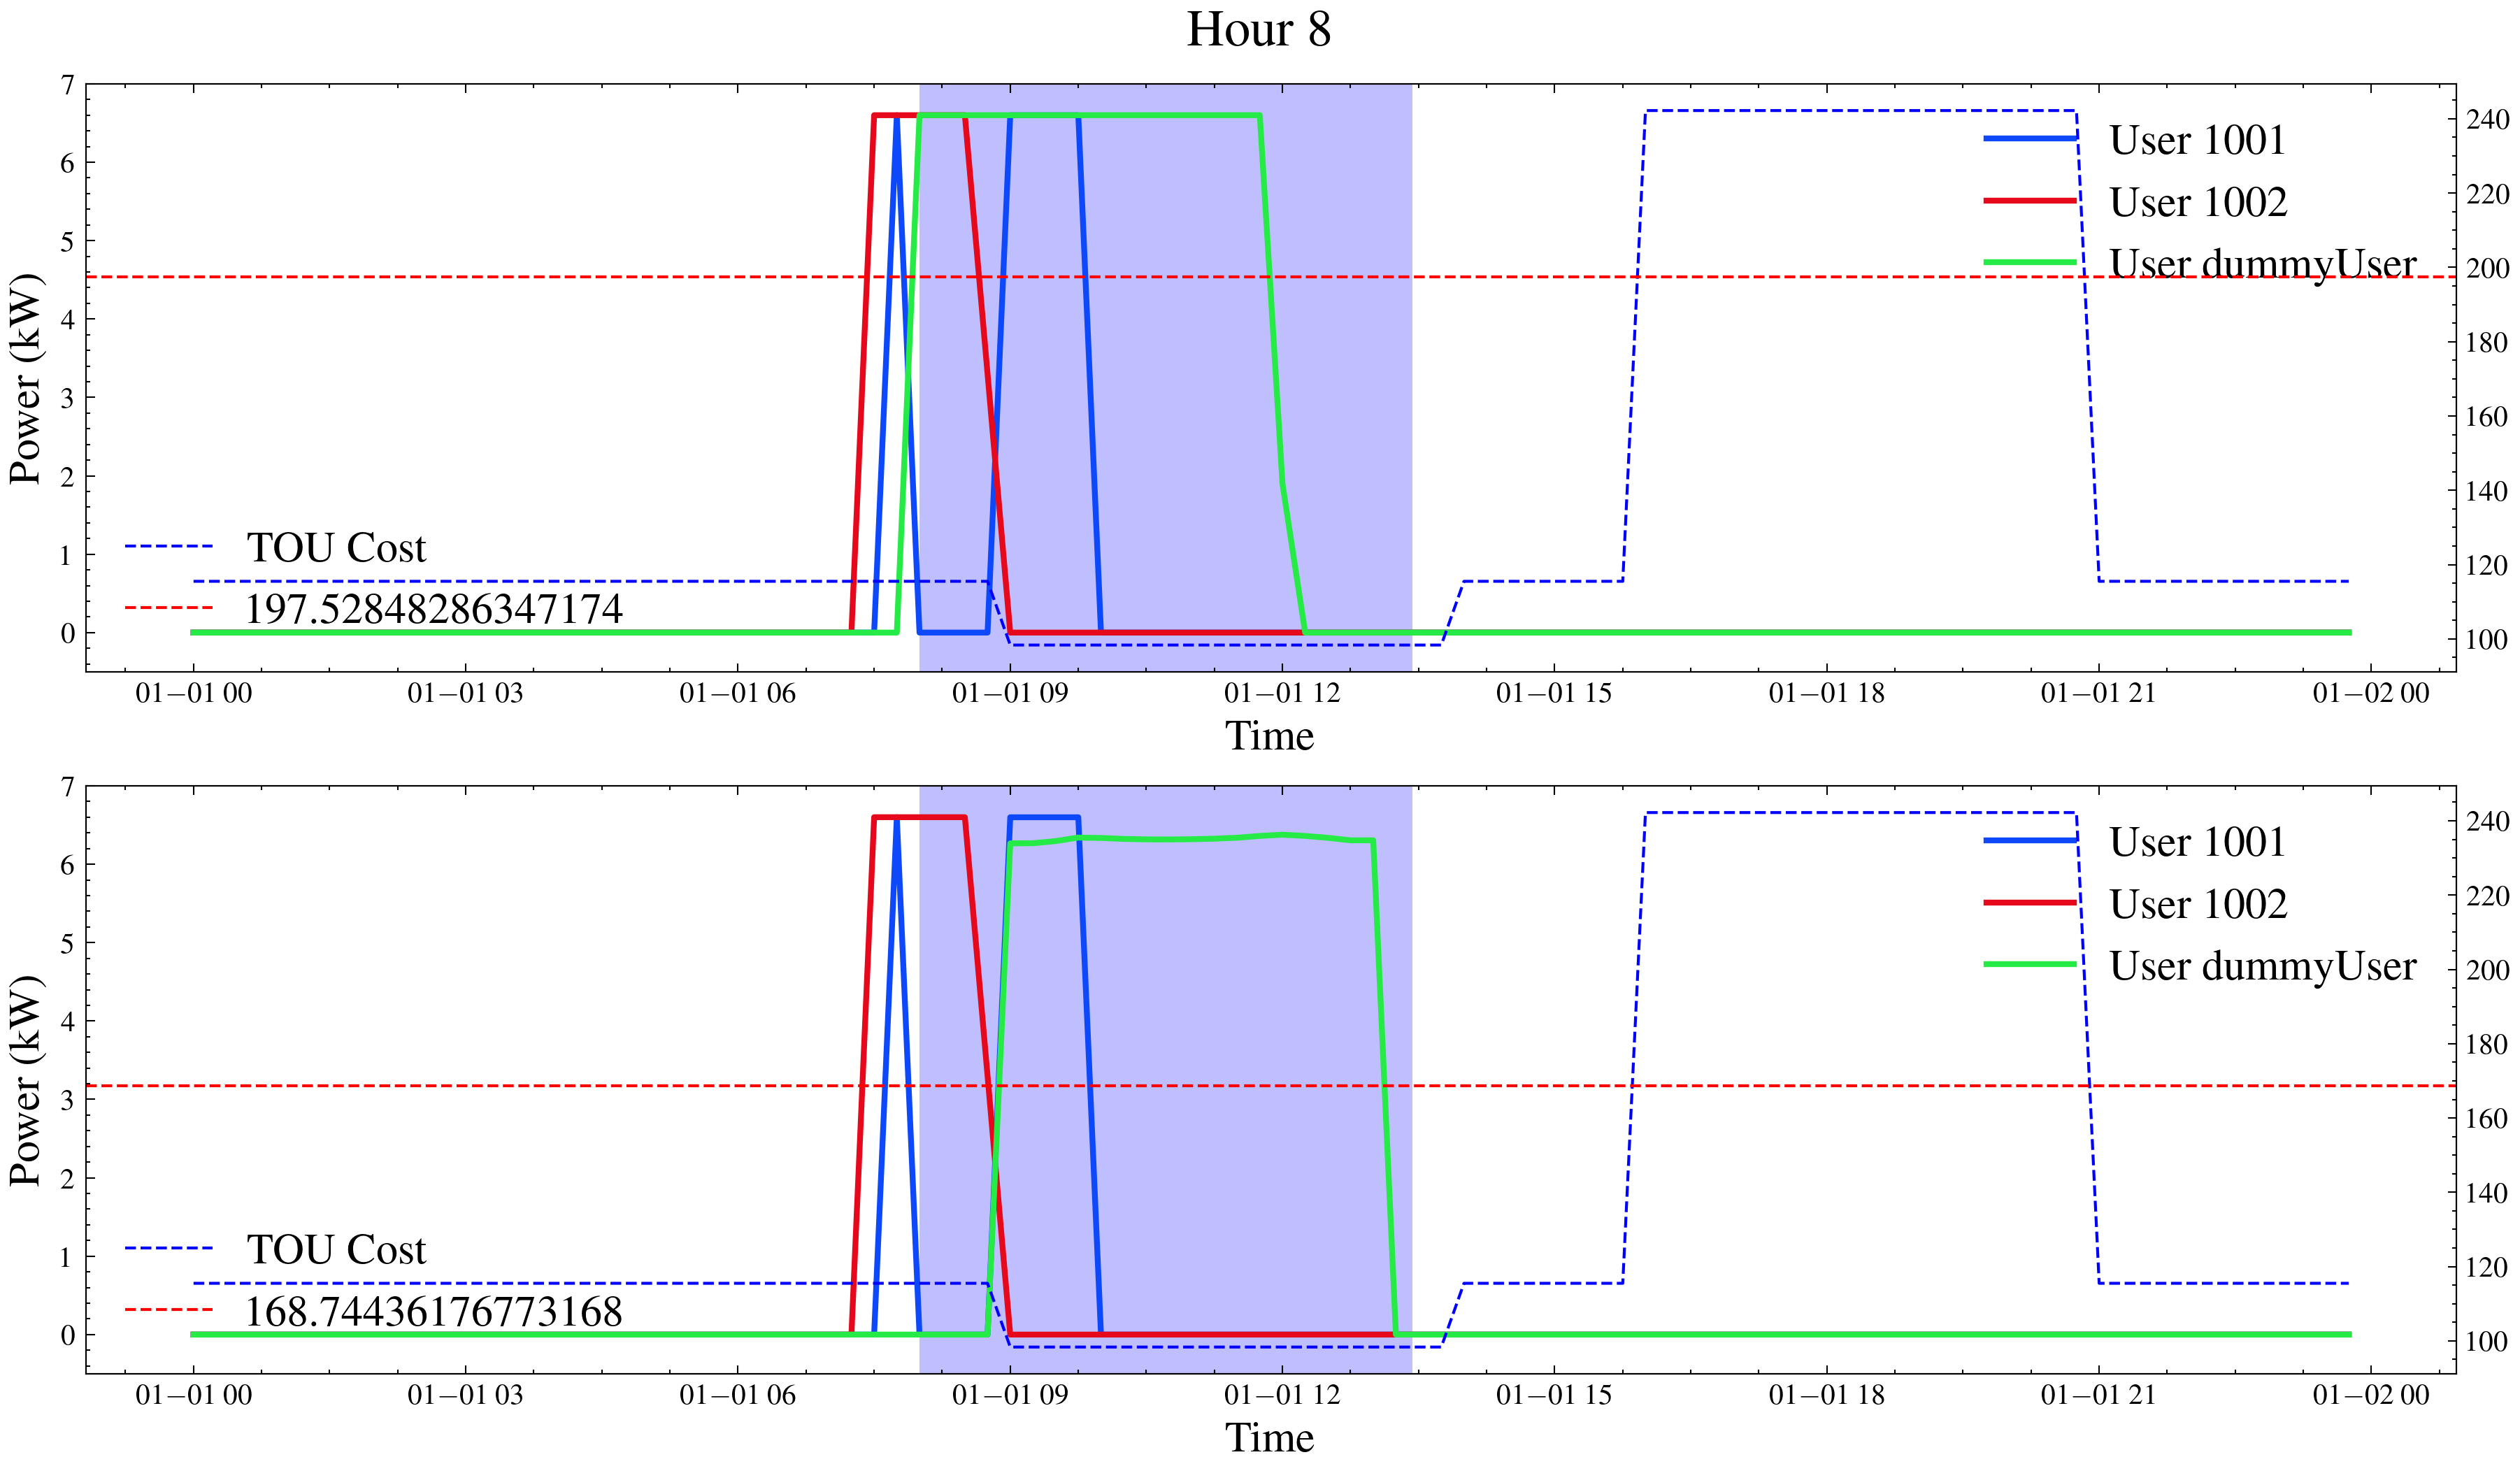

In [27]:
high_TOU = TOU_tariff * 6.6
steps_in_hr = 4
eff = 1
interval_size_minutes = int(60 * delta_t)
assert steps_in_hr == int(1/delta_t)

timezone = datetime.timezone(datetime.timedelta(hours=0))

arrHour = 8
station_pow_max = 6.6
interval_size_hour = 0.25

e_need = expected_demand.loc[(arrHour, 1) ,"estEnergykWh"]
duration = expected_demand.loc[(arrHour, 1) ,"estDurationHrs"]

arrival_interval = int(arrHour *steps_in_hr)
duration_interval =  int(duration * 60 / interval_size_minutes)


###### HAVE THE SAME DISCRETIZATION HERE IN THE OPTIMIZER ############################
N_asap = math.ceil((e_need / station_pow_max / eff * int(1 / interval_size_hour)))
N_asap_remainder = (e_need / station_pow_max / eff * int(1 / interval_size_hour)) % 1

sch_power_list = []
reg_power_list = []

for user in States["hour" + str(arrHour)]["SCH"]["sessions"]:
    user_key = user["dcosId"]
    sch_arr = np.zeros((96,1))
    start_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][0][0]), timezone)
    start_time = float(start_time_obj.hour + start_time_obj.minute / 60)
    arrival_interval = int(start_time * steps_in_hr)

    end_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][-1][0]), timezone)
    end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
    end_interval = int(end_time * steps_in_hr)
    duration_interval = end_interval - arrival_interval

    timerange = pd.date_range("1/1/2021", periods=96, freq="{}min".format(interval_size_minutes ))
    sch_arr[arrival_interval:(arrival_interval+duration_interval)] = (user["optPower"][:, 1].reshape((duration_interval,1))) / 1000
    sch_power_list.append(sch_arr)

for user in States["hour" + str(arrHour)]["REG"]["sessions"]:
    user_key = user["dcosId"]
    reg_arr = np.zeros((96,1))
    start_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][0][0]), timezone)
    start_time = float(start_time_obj.hour + start_time_obj.minute / 60)
    arrival_interval = int(start_time * steps_in_hr)

    end_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][-1][0]), timezone)
    end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
    end_interval = int(end_time * steps_in_hr)
    duration_interval = end_interval - arrival_interval

    timerange = pd.date_range("1/1/2021", periods=96, freq="{}min".format(interval_size_minutes ))
    reg_arr[arrival_interval:(arrival_interval+duration_interval)] = (user["optPower"][:, 1].reshape((duration_interval,1))) / 1000
    reg_power_list.append(reg_arr)

fig,(ax1, ax2) = plt.subplots(2,1,figsize=(12,7) ,)

for i, profile in enumerate(reg_power_list):
    ax1.plot(timerange, profile, label = "User " + str(States["hour" + str(arrHour)]["REG"]["sessions"][i]["dcosId"]), linestyle = "-", linewidth = 2)
ax = ax1.twinx()
ax.plot(timerange , high_TOU, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")


reg_price_cents_hour = expected_demand.loc[(arrHour, 1), 'reg_centsPerHr']
ax.axhline(reg_price_cents_hour  ,linestyle='--',color='red',
           label = reg_price_cents_hour)
ax.legend(loc=3)

for i, profile in enumerate(sch_power_list):
    ax2.plot(timerange, profile, label = "User " + str(States["hour" + str(arrHour)]["SCH"]["sessions"][i]["dcosId"]), linestyle = "-", linewidth = 2)
ax = ax2.twinx()
sch_price_cents_hour = expected_demand.loc[(arrHour, 1), 'sch_centsPerHr']
ax.plot(timerange , high_TOU, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")
ax.axhline(sch_price_cents_hour  ,linestyle='--',color='red',
           label =sch_price_cents_hour)
ax.legend(loc=3)
plot_arrival_departure([ax1,ax2], arrHour, 0, int(arrHour + duration),
                       int(60 * ((arrHour + duration) % int(arrHour + duration))))

# plot_max_min_power([ax1,ax2],6.6)
for ax in [ax1,ax2]:
    ax.set_ylim(-0.5,7)
    ax.legend(loc=0)
    ax.legend(loc=0)
    ax.set_xlabel("Time")
    ax.set_ylabel("Power (kW)")


fig.suptitle("Hour {}".format(arrHour))

In [28]:
States

defaultdict(dict,
            {'hour8': {'SCH': {'monthlyPeak': 19.14,
               'timeStamp': 1675756800,
               'sessions': [{'dcosId': 1001,
                 'choice': 'SCH',
                 'powerRate': 'HIGH',
                 'energyNeeded': 8250,
                 'deadline': 1675759500,
                 'optPower': array([[1675755000,          0],
                        [1675755900,       6600],
                        [1675756800,          0],
                        [1675757700,          0],
                        [1675758600,          0],
                        [1675759500,          0],
                        [1675760400,       6599],
                        [1675761300,       6599],
                        [1675762200,       6599],
                        [1675763100,       6599]])},
                {'dcosId': 1002,
                 'choice': 'REG',
                 'powerRate': 'HIGH',
                 'energyNeeded': 9075,
                 'deadline': 1675

In [29]:
res

{'e_need': 5.186555555555556,
 'z': array([25.37515551, 29.9598721 ,  0.        ,  1.        ]),
 'z_hr': array([167.4760264 , 197.73515583,   0.        ,   6.6       ]),
 'tariff_sch': 25.37515551484624,
 'tariff_reg': 29.95987209510404,
 'sch_centsPerHr': 167.47602639798518,
 'reg_centsPerHr': 197.73515582768664,
 'power_rate': 6.6,
 'new_peak_sch': array([12.]),
 'new_peak_reg': array([12.]),
 'sch_e_delivered': array([[-0.        ],
        [ 1.29231351],
        [ 2.58462702],
        [ 3.89424205],
        [ 5.18655556]]),
 'sch_powers': array([[6.6       ],
        [6.6       ],
        [6.6       ],
        [0.94622222]]),
 'reg_powers': array([[6.6       ],
        [6.6       ],
        [6.6       ],
        [0.94622222]]),
 'sch_max': 5.238460120397522,
 'reg_max': 6.6,
 'v': array([0.4029, 0.3251, 0.2719]),
 'prob_flex': 0.4029,
 'prob_asap': 0.3251,
 'prob_leave': 0.2719,
 'N_sch': 4,
 'N_reg': 4,
 'J': array([122.37711292, 107.04722593, 106.73974397, 106.43072138]),
 'J_su